In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropFeatures

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Built-in library
import itertools
import re
import json
import logging
import typing as tp


# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# Helper Functions


def set_up_logger(delim: str = "::") -> tp.Any:
    """This is used to create a basic logger."""
    format_ = f"[%(levelname)s] {delim} %(asctime)s {delim} %(message)s"
    logging.basicConfig(level=logging.INFO, format=format_)
    logger = logging.getLogger(__name__)
    return logger


def load_data(*, filepath: str) -> pd.DataFrame:
    """This is used to load data as a dataframe.

    Params:
        filepath (str): The filepath of the input data.

    Returns:
        df (pd.Dataframe): A DF containing the input data.
    """
    df = pd.read_csv(filepath)
    logger.info(f"Shape of df: {df.shape}\n")
    return df

In [3]:
logger = set_up_logger()

# Load data
df = load_data(filepath="../data/titanic_train.csv")

df.head()

[INFO] :: 2023-01-14 14:15:05,638 :: Shape of df: (891, 12)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Split the data into train and test sets
target = "Survived"
test_size = 0.1
random_state = 123


X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

X_train.shape, X_test.shape

((801, 11), (90, 11))

In [5]:
# Split the data into numerical and categorical variables
num_vars = [*X_train.select_dtypes(exclude="O").columns]
cat_vars = [*X_train.select_dtypes(exclude=["int", "float"]).columns]

num_vars, cat_vars

(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
 ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])

### Numerical Variables

In [6]:
# Check for missing values
num_vars_wf_na = [var for var in num_vars if X_train[var].isna().sum() > 0]

# Percentage of missing values
X_train[num_vars_wf_na].isna().mean().mul(100)

Age    20.099875
dtype: float64

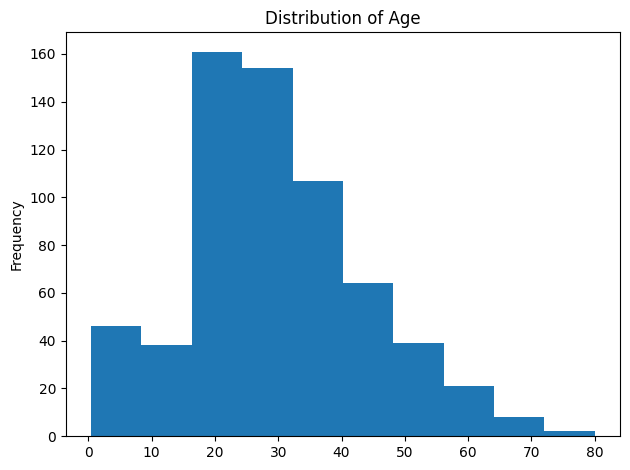

In [7]:
X_train["Age"].plot(kind="hist")
plt.title("Distribution of Age")

plt.tight_layout()
plt.show()

In [8]:
X_train[num_vars].describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,801.000000,801.000000,640.000000,801.000000,801.000000,801.000000
mean,449.387016,2.309613,29.885812,0.505618,0.375780,32.165636
std,257.392366,0.834578,14.386277,1.098991,0.799914,50.871077
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,229.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,451.000000,3.000000,28.250000,0.000000,0.000000,13.862500
75%,669.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# Replace the missing values in numerical variables
mean_imputer = MeanMedianImputer(imputation_method="median", variables=num_vars_wf_na)
X_train = mean_imputer.fit_transform(X_train)
X_test = mean_imputer.transform(X_test)

# Verify
X_train[num_vars_wf_na].isna().mean().mul(100), X_test[
    num_vars_wf_na
].isna().mean().mul(100)

(Age    0.0
 dtype: float64,
 Age    0.0
 dtype: float64)

In [10]:
# Check Cardinality
for var in num_vars:
    uniq_vals = X_train[var].nunique()
    print(f"{var}: {uniq_vals} unique values")

PassengerId: 801 unique values
Pclass: 3 unique values
Age: 87 unique values
SibSp: 7 unique values
Parch: 7 unique values
Fare: 238 unique values


In [11]:
# Determine the discrete variables
thresh = 20
discrete_vars = [var for var in num_vars if X_train[var].nunique() < thresh]

num_vars = [*set(num_vars).difference(set(discrete_vars))]

num_vars, discrete_vars

(['Age', 'Fare', 'PassengerId'], ['Pclass', 'SibSp', 'Parch'])

In [12]:
# Cast to categorical
X_train[discrete_vars] = X_train[discrete_vars].astype(str)
X_test[discrete_vars] = X_test[discrete_vars].astype(str)


# Check for `rare` labels
for var in discrete_vars:
    labels = X_train[var].value_counts(normalize=True).mul(100)
    print(f"{var}: \n{labels} unique values\n")

Pclass: 
3    55.056180
1    24.094881
2    20.848939
Name: Pclass, dtype: float64 unique values

SibSp: 
0    69.163546
1    22.971286
2     2.996255
3     1.872659
4     1.622971
8     0.873908
5     0.499376
Name: SibSp, dtype: float64 unique values

Parch: 
0    76.279650
1    13.358302
2     8.739076
5     0.624220
3     0.624220
4     0.249688
6     0.124844
Name: Parch, dtype: float64 unique values



In [13]:
# Encode Rare Labels
rare_label_enc = RareLabelEncoder(tol=0.05, n_categories=5, variables=discrete_vars)
X_train = rare_label_enc.fit_transform(X_train)
X_test = rare_label_enc.transform(X_test)

# Check for `rare` labels
result = {}
for var in discrete_vars:
    labels = X_train[var].value_counts(normalize=True).mul(100)
    result[var] = labels.to_dict()

result

{'Pclass': {'3': 55.0561797752809,
  '1': 24.094881398252184,
  '2': 20.848938826466917},
 'SibSp': {'0': 69.16354556803995,
  '1': 22.971285892634207,
  'Rare': 7.865168539325842},
 'Parch': {'0': 76.2796504369538,
  '1': 13.358302122347066,
  '2': 8.739076154806492,
  'Rare': 1.6229712858926344}}

In [14]:
result = {}
for var in discrete_vars:
    labels = X_test[var].value_counts(normalize=True).mul(100)
    result[var] = labels.to_dict()

result

{'Pclass': {'3': 55.55555555555556,
  '1': 25.555555555555554,
  '2': 18.88888888888889},
 'SibSp': {'0': 60.0, '1': 27.77777777777778, 'Rare': 12.222222222222221},
 'Parch': {'0': 74.44444444444444,
  '1': 12.222222222222221,
  '2': 11.11111111111111,
  'Rare': 2.2222222222222223}}

In [15]:
# Scale the variables
yea_johnson_transf = YeoJohnsonTransformer(variables=num_vars)
X_train = yea_johnson_transf.fit_transform(X_train)
X_test = yea_johnson_transf.transform(X_test)

X_train.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
677,154.591662,3,"Turja, Miss. Anna Sofia",female,11.675611,0,0,4138,2.137198,NaN,S
547,132.316212,2,"Padro y Manent, Mr. Julian",male,16.925884,0,0,SC/PARIS 2146,2.386117,NaN,C
317,88.808206,2,"Moraweck, Dr. Ernest",male,28.678869,0,0,29011,2.393275,NaN,S


### Categorical Variables

In [16]:
# Check for missing values
cat_vars_wf_na = [var for var in cat_vars if X_train[var].isna().sum() > 0]

# Percentage of missing values
X_train[cat_vars_wf_na].isna().mean().mul(100)

Cabin       77.278402
Embarked     0.249688
dtype: float64

In [17]:
# Drop variable(s)
features_to_drop = ["Cabin", "Name", "Ticket"]
drop_feats = DropFeatures(features_to_drop=features_to_drop)

X_train = drop_feats.fit_transform(X_train)
X_test = drop_feats.transform(X_test)

X_train.columns, X_test.columns

(Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
        'Embarked'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
        'Embarked'],
       dtype='object'))

In [18]:
cat_vars

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [19]:
cat_vars = [*set(cat_vars).difference(set(features_to_drop))]

cat_vars, features_to_drop

(['Sex', 'Embarked'], ['Cabin', 'Name', 'Ticket'])

In [20]:
# Replace the missing values in categorical variables
cat_vars_wf_na = ["Embarked"]
cat_imputer = CategoricalImputer(imputation_method="frequent", variables=cat_vars_wf_na)
X_train = cat_imputer.fit_transform(X_train)
X_test = cat_imputer.transform(X_test)

# Verify
X_train[cat_vars_wf_na].isna().mean().mul(100), X_test[
    cat_vars_wf_na
].isna().mean().mul(100)

(Embarked    0.0
 dtype: float64,
 Embarked    0.0
 dtype: float64)

In [21]:
X_train[cat_vars + discrete_vars].info()

cat_vars

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 677 to 510
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sex       801 non-null    object
 1   Embarked  801 non-null    object
 2   Pclass    801 non-null    object
 3   SibSp     801 non-null    object
 4   Parch     801 non-null    object
dtypes: object(5)
memory usage: 37.5+ KB


['Sex', 'Embarked']

In [22]:
# Encode Categorical Variables
cat_enc = OrdinalEncoder(encoding_method="ordered", variables=cat_vars + discrete_vars)
X_train = cat_enc.fit_transform(X_train, y_train)
X_test = cat_enc.transform(X_test)

# Verify
X_train[num_vars + cat_vars + discrete_vars].head(3)

,Age,Fare,PassengerId,Sex,Embarked,Pclass,SibSp,Parch
677,11.675611,2.137198,154.591662,1,0,0,1,1
547,16.925884,2.386117,132.316212,0,2,1,1,1
317,28.678869,2.393275,88.808206,0,0,1,1,1


In [28]:
# Scale the  variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verify
X_train[:5], X_test[:5]

(array([[ 0.88201627, -0.827746  ,  1.36408001, -0.8790148 , -0.28269331,
         -0.46760989, -0.54926346, -0.58185434],
        [ 0.44445804,  0.3712134 , -0.73309483, -0.05227827, -0.28269331,
         -0.46760989, -0.21202015,  1.97894415],
        [-0.41017275,  0.3712134 , -0.73309483,  1.7984107 , -0.28269331,
         -0.46760989, -0.20232293, -0.58185434],
        [-0.64157441, -0.827746  , -0.73309483, -2.32117745, -2.15407626,
          0.9145138 ,  0.57948013, -0.58185434],
        [-0.5909312 ,  1.5701728 , -0.73309483,  0.60496593, -0.28269331,
          2.29663748,  0.52692599,  1.97894415]]),
 array([[-1.04023778, -0.827746  ,  1.36408001, -2.57224094,  1.58868965,
          2.29663748, -0.42779082, -0.58185434],
        [ 0.36421051, -0.827746  , -0.73309483, -0.05227827, -0.28269331,
         -0.46760989, -0.85226245,  1.97894415],
        [ 0.10645552,  1.5701728 , -0.73309483,  0.08215885, -0.28269331,
         -0.46760989,  0.46211431,  1.97894415],
        [-1.04